# Машинное обучение, ВМК МГУ

# Практическое задание 1. Обучение без учителя.

## Общая информация
Дата выдачи: 22.02.2024

Мягкий дедлайн: 07.03.2024 23:59 MSK

Жёсткий дедлайн: 14.03.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-1-Username.ipynb

Username — ваша фамилия на латинице

## О задании



В этом задании вам предлагается поработать с различными методами кластеризации и посмотреть их работу на различных данных

In [ ]:
import pandas as pd
import numpy as np

np.random.seed(0xFFFFFFF)

## Часть 1. Тематическое моделирование текстов.

В этом задании мы сравним разные алгоритмы кластеризации для задачи тематического моделирования.

**Задание 1.1 (1 балл).** Для начала реализуйте алгоритм спектральной кластеризации, который упоминался на лекции. Для этого разберитесь с кодом шаблона, данного ниже, и допишите недостающую функцию. Здесь необходимо использовать вариацию с ненормированным лапласианом.

In [ ]:
from sklearn.base import ClusterMixin
from sklearn.cluster import KMeans


class GraphClustering(ClusterMixin):
    def __init__(self, n_clusters=8, n_components=None, **kwargs):
        '''
        Spectral clustering algorithm
        param n_clusters: number of clusters to form
        param n_components: number of eigenvectors to use
        '''

        if n_components is None:
            n_components = n_clusters

        self.n_components = n_components
        self.kmeans = KMeans(n_clusters=n_clusters, **kwargs)

    def fit_predict(self, X, y=None):
        '''
        Perform spectral clustering from graph adjacency matrix
        and return vertex labels.
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, ) - vertex labels
        '''

        eigenvectors = self._generate_eigenvectors(X)
        labels = self.kmeans.fit_predict(eigenvectors[:, 1:])
        return labels

    def _generate_eigenvectors(self, X):
        '''
        Compute eigenvectors for spectral clustering
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, n_components) - eigenvectors
        '''

        # YOUR CODE HERE ‿︵‿︵ヽ(°□° )ノ︵‿︵‿
        raise NotImplementedError

Перед тем, как переходить к следующему заданию, протестируйте свое решение.

In [ ]:
n_blocks, n_vertices = 10, 1000
block_vertices = n_vertices // n_blocks

X = np.zeros((n_vertices, n_vertices))
for i in range(0, n_vertices, block_vertices):
    X[i:i + block_vertices, i:i + block_vertices] = np.sqrt(i + 1)

graph_clustering = GraphClustering(n_clusters=n_blocks)
labels = graph_clustering.fit_predict(X)

true_labels = np.zeros(n_vertices, dtype=np.int32)
for i in range(0, n_vertices, block_vertices):
    true_labels[i:i + block_vertices] = labels[i]

assert labels.shape == (n_vertices, )
assert np.all(np.bincount(labels) == np.full(n_blocks, block_vertices))
assert np.all(labels == true_labels)

**Задание 1.2 (0.5 балла)** Теперь приступим к применению разных алгоритмов кластеризации для одной из самых популярных задач обучения без учителя: задачи тематического моделирования текстов.

Допустим, нам доступна некоторая коллекция документов без разметки, и мы хотим автоматически выделить несколько тем, которые встречаются в документах, а также присвоить каждому документу одну (или несколько) тем. То есть, фактически, перед вами стоит задача кластеризации текстов с тем лишь дополнением что требется не только разбить тексты на группы, но и выделить ключевые слова, определяющие каждую тему.

Мы будем работать с новостными статьями BBC за 2004-2005 годы. Скачайте данные по [ссылке](https://www.kaggle.com/hgultekin/bbcnewsarchive).

In [1]:
data = pd.read_csv('bbc-news-data.csv', sep='\t')
data.sample(5)

Как вы могли заметить, данные уже содержат разметку по тематике (колонка category). В этой части мы забудем, что она есть, и будем работать только с текстовыми данными. Проведем предобработку текста, состоящую из следующих пунктов:

* Объединим заголовок и содержание статьи в одно поле.
* Приведем текст к нижнему регистру, разобьем его на токены.
* Оставим только буквенные слова (удалив, таким образом, пунктуацию и числа).
* Применим лемматизацию.
* Удалим стоп-слова.


Для визуализации частот слов в текстах мы будем использовать [облака тегов](https://en.wikipedia.org/wiki/Tag_cloud).

In [ ]:
from wordcloud import WordCloud

def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

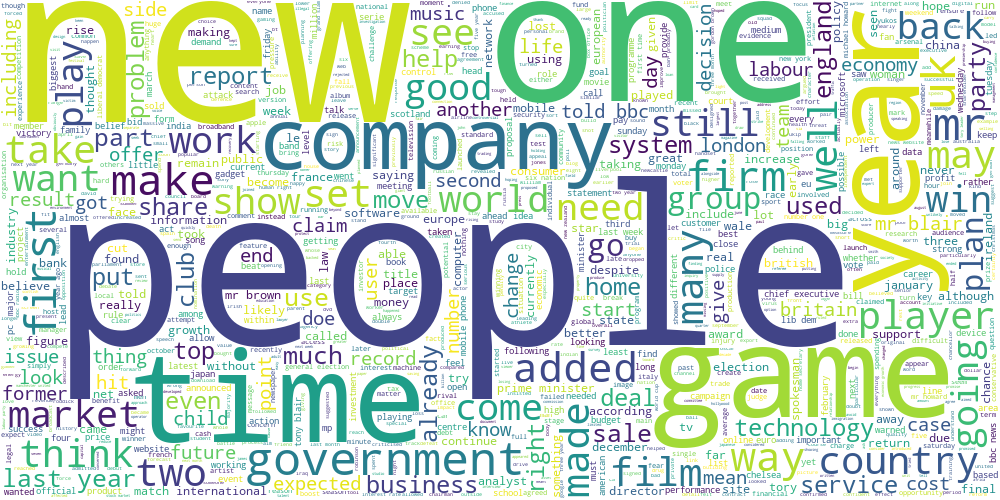

In [ ]:
draw_wordcloud(data.text)

**Задание 1.3 (1 балл).** Начнем с простого: обучите алгоритм K-Means на tf-idf представлениях текстов. При обучении tf-idf векторайзера рекомендуется отбрасывать редко встречающиеся слова. Возьмите не очень большое число кластеров, чтобы было удобно интерпретировать получившиеся темы (например, `n_clusters` = 8). Постройте облака тегов для текстов из разных кластеров. (?) Получились ли темы интерпретируемыми? Попробуйте озаглавить каждую тему.

**Ответ:**

**Задание 1.4 (0.5 балла).** Попробуем другой способ выделить ключевые слова для каждой темы. Помимо непосредственного разбиения объектов алгоритм K-Means получает центр каждого кластера. Попробуйте взять центры кластеров и посмотреть на несколько слов с наибольшими числовыми значениями. (?) Соответствуют ли полученные слова облакам тегов из прошлого задания?

**Ответ:**

**Задание 1.5 (можно получить 1.5, 1 или 2.5 баллов)** Попробуем усовершенствовать метод. Реализуйте в приведенном ниже шаблоне ядерный K-means(1.5 баллов) или эллипсоидный метод(1 балл) (можно оба сразу, тогда баллы сложатся). И попробуйте применить его для решаемой задачи. (?)Насколько существенно отличаются  центры кластеров и облака тегов от таковых для предыдущих методов?

In [ ]:
class KernelKMeans:
    def __init__(self, n_clusters, iters):
        """
        KMeans Class constructor.

        Args:
        n_clusters (int) : Number of clusters used for partitioning.
        iters (int) : Number of iterations until the algorithm stops.

        """
        pass
 
    def initialize_clusters(self, X, n_clusters):
        """
        Initialize centroids.

        Args:
        X (ndarray): Dataset samples
        n_clusters (int): Number of clusters

        Returns:
        centroids (ndarray): Initial position of centroids
        """
        pass

 
    def fit_predict(self, X):
        """
        Implementation of the kernel KMeans algorithm.

        Args:
        X (ndarray): Dataset samples

        Returns:
        centroids (ndarray): Computed centroids
        labels (ndarray): Predicts for each sample in the dataset.
        """
        pass
    
    def get_centroids(self):
        """
        Return the computed centroids
        """
        pass

**Задание 1.6 (0.5 балла).** Теперь попробуем сравнить три разных алгоритма кластеризации. Получите три разбиения на кластеры с помощью алгоритмов K-Means(любого понравившегося), DBSCAN(можно взять готовый из sklearn) и спектральной кластеризации, реализованной вами выше. Для K-Means и спектральной кластеризации возьмите одинаковое небольшое число кластеров, подберите параметр `eps` метода DBSCAN так, чтобы получить приблизительно такое же число кластеров.

(?) Теперь постройте облака слов и снова проинтерпретируйте темы. 

**Задание 1.6 (1 балл).** Также, для анализа качества кластеризации иногда бывает полезно "посмотреть" накластеры. Обучите двухмерные t-SNE представления над tf-idf признаками текстов. Визуализируйте эти представления для каждого алгоритма, раскрасив каждый кластер своим цветом. Лучше всего расположить визуализации на одном графике на трех разных сабплотах. Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 14})
sns.set_style('whitegrid')

(?) Прокомментируйте получившиеся результаты. Какой баланс кластеров получился у разных методов? Сделаете выводы о каждом исследованном в части 1 алгоритме и их применимости к задаче тематического моделирования. **За отсутствие выводов будет наложен штраф до 2.5 баллов.**

**Ответ:**

## Часть 2. Transfer learning для задачи классификации текстов.

**Задание 3.1 (4 балла).** Вспомним, что у нас есть разметка для тематик статей. Просимулируем ситуацию слабой разметки, которая часто встречается в реальных данных. Разделим обучающую выборку в пропорции 1:13:6. 70% выборки будем использовать для обучения, а остальные 30% для валидации

Обучите метрику Махаланобиса любыми **тремя**  методами (отсюда)[http://contrib.scikit-learn.org/metric-learn/supervised.html] только на маленьком куске (5%) обучающей выборки. Кластеризуйте данные методом k-means с обученными метриками  и проанализирйте полученные результаты. 

Сравните 3 подхода к класификации:

Логистическая регрессия на tf-idf признаках

K-Means с евклидовой метрикой на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров

K-Means с обученной метрикой на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров

Все unsupervised-алгоритмы (векторайзеры и алгоритмы кластеризации) запускайте на всей обучающей выборке целиком (70%), а итоговый классификатор и обучение метрики обучайте только на ее маленьком куске (5%). Подберите гиперпараметры моделей по качеству на валидационной выборке (30%), а затем оцените качество на тестовой выборке (не скромничайте при подборе числа кластеров, сейчас нас интересует не интерпретируемое разбиение выборки, а итоговое качество классификации).

**В качестве метрики качества используйте accuracy**

Можете провести дополнительные исследования с другими методами кластеризации и получить более высокое качество. За качественные исследования с хорошим описанием можно получить **до 2 бонусных баллов**.

(?) Сделайте выводы о применимости методов кластеризации для улучшения качества классификации. **За отсутствие выводов будет наложен штраф до 2.5 баллов.**

**Ответ:**